## Imports

In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm

import pandas as pd
import numpy as np

from datetime import datetime
import time

## Data laoding from CSV
### Stockdata
* Load data from CSV

In [2]:
stock_list = pd.read_csv('clean_data.csv',sep=',')
u_symbol = stock_list['symbol'].unique()
date = pd.Series(stock_list['datetime'])
stock_list.drop(['datetime'],axis=1,inplace=True)
stock_list['date'] = date.apply(lambda x: np.datetime64(x))
stock_data = {}

for symbol in u_symbol:
    stock_data[symbol] = stock_list[stock_list['symbol'] == symbol]

stock_data[list(stock_data.keys())[0]]

,open,high,low,close,volume,symbol,log_returns,date
0,32.30,33.58,32.30,32.84,7315000.0,1179.HK,0.056371,2020-09-23
1,34.08,34.20,33.50,33.73,2797160.0,1179.HK,0.026740,2020-09-24
2,33.12,33.12,32.30,32.62,3964430.0,1179.HK,-0.033462,2020-09-25
3,32.68,33.22,32.68,33.08,763500.0,1179.HK,0.014003,2020-09-28
4,33.58,34.18,33.58,33.99,2398130.0,1179.HK,0.027137,2020-09-29
...,...,...,...,...,...,...,...,...
838,29.20,29.20,28.30,28.85,2695218.0,1179.HK,-0.012059,2024-02-22
839,29.10,30.05,29.10,29.70,1548300.0,1179.HK,0.029037,2024-02-23
840,30.35,31.00,30.30,30.40,3111600.0,1179.HK,0.023296,2024-02-26
841,29.60,30.10,29.15,29.95,2316600.0,1179.HK,-0.014913,2024-02-27


In [3]:
# stock_list = pd.read_csv('log_returns_yahoo.csv')
# date = pd.Series(stock_list['date'])
# stock_list.drop(['date'],axis=1,inplace=True)
# stock_data = {}
# date = date.apply(lambda x: np.datetime64(x))

# for symbol in stock_list:
#     df = pd.DataFrame({'adj_close': stock_list[symbol], 'date': date})
#     stock_data[symbol] = df


<Axes: xlabel='log_returns', ylabel='date'>

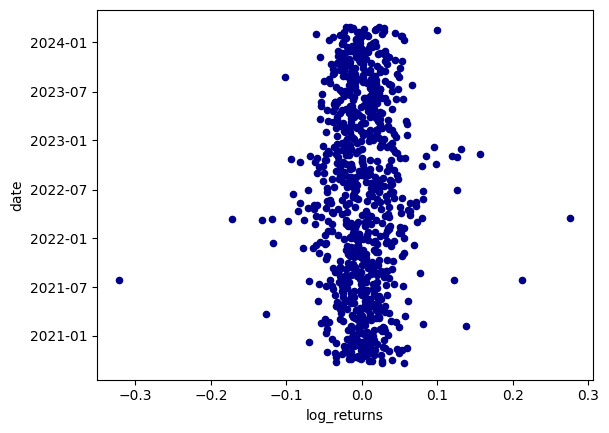

In [4]:
# visualize one stock
stock_data[list(stock_data.keys())[0]].plot.scatter(x='log_returns',y='date',c='DarkBlue')

### Short-selling-reports

In [5]:
short_list = pd.read_excel('stocks_with_listings.xlsx')
print(short_list.head)

<bound method NDFrame.head of      Unnamed: 0     Research Source       Date                       Stock  \
0             0  Kerrisdale Capital 2024-02-13                   Altimmune   
1             1  Kerrisdale Capital 2023-10-10               Joby Aviation   
2             2  Kerrisdale Capital 2023-09-18                      Tilray   
3             3  Kerrisdale Capital 2023-06-12                 Carvana Co.   
4             4  Kerrisdale Capital 2023-03-23  Uranium Energy Corporation   
..          ...                 ...        ...                         ...   
324         324    Iceberg Research 2015-02-15         Noble Group Limited   
325         325  J Capital Research 2024-01-18                  Hut 8 Corp   
326         326                 NaN 2023-11-30             ISPR Technology   
327         327                 NaN 2023-11-21    Microvast Holdings, Inc.   
328         328                 NaN 2023-06-27            American Lithium   

    SYMBOL  Data Source  Shortsel

## Label Rows
* read time shifted `adj_close` into `signal` such that it can be compared to current date in one row without reverse lookupQQ
* compare previous day and set 1 if stock has risen

In [6]:
# label function
def label_row(row):
    if (row['signal'] - row['log_returns']) > 0:
        return 1
    else:
        return 0
def label_df(df):
    df['signal'] = df['log_returns'].shift(1)
    df.fillna(0)
    df['signal'] = df.apply(label_row,axis=1)
    return df

In [7]:
for ticker in stock_data:
    stock_data[ticker] = label_df(stock_data[ticker])

C:\Users\Admin\AppData\Local\Temp\ipykernel_19528\1523053876.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = df['log_returns'].shift(1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19528\1523053876.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = df.apply(label_row,axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19528\1523053876.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

## Create Bands

In [8]:
for i in stock_data:
    df = stock_data[i]
    if(df['signal'].shape[0] < 10):
        print(i)
        print(df['signal'].shape)

## Filter training data

In [9]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [10]:
stocks_after_report = {}

for index, row in short_list.iterrows():
    symbol = row['SYMBOL']
    date_report = row['Date']
    if symbol in list(stock_data.keys()):
        stock_df = stock_data[symbol]
        stock_start_date = nearest(np.array(stock_df['date']),date_report)
        condition = stock_df['date'] == stock_start_date
        start_index = stock_df.index[condition][0]
        # gets all entries of the stock after the shortselling repport for this stock has been rleases
        if(start_index > stock_df.index[-1]):
            print("start index df: {}, end index df: {}, date after report: {}".format(stock_df.index[0],stock_df.index[-1],start_index))
        result = stock_df.loc[start_index:]
        # replace date with column that indicates how many days past rlease have passed
        index = np.arange(0,len(result.date))
        result['index'] = index
        # save each dataset
        stocks_after_report[symbol] = result



C:\Users\Admin\AppData\Local\Temp\ipykernel_19528\3953367979.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['index'] = index
C:\Users\Admin\AppData\Local\Temp\ipykernel_19528\3953367979.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['index'] = index
C:\Users\Admin\AppData\Local\Temp\ipykernel_19528\3953367979.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

## Create Testsplit
* We create a testsplit at a certain date which allows for roughly 70% of the data to be before it for training.
* The other 30% will be after the date, we ensure this way that when we do out of sample testing that the training wasnt
"poisoned" with future data.

In [11]:
# ABAT -> 2016-02-25
# Make sure all dates are in datetime format
short_list['Date'] = short_list['Date'].apply(lambda x: np.datetime64(x)) 
# Sort list by date ascending
short_list.sort_values(by=['Date'], inplace=True, ascending=True)
# Remove entries that arent in the dataset with 
short_list = short_list[short_list['SYMBOL'].isin(stocks_after_report)]
# Get amount of entries
sl_size = short_list.shape[0]
# Get index up to which 70% of the entries are. 
position_training_block = int(sl_size*0.7)
# Create Testsplit
train_list = short_list.iloc[:position_training_block]
test_list = short_list.iloc[position_training_block:]

X_train = []
Y_train = []

X_test = []
Y_test = []

# print(stocks_after_report['ABAT'])

#TODO
for ticker in train_list['SYMBOL']:
    x = np.array(stocks_after_report[ticker][['index','log_returns']])
    # # x = np.array(stock_data[ticker].drop(['signal','date'],axis=1))
    # if np.isnan(x.all()):
    #     print(ticker)
    y = np.array(stocks_after_report[ticker][['signal']].shift(1).fillna(0))
    X_train.append(x)
    Y_train.append(y)

for ticker in test_list['SYMBOL']:
    x = np.array(stocks_after_report[ticker][['index','log_returns']])
    X_test.append(x)
    Y_test.append(np.array(stocks_after_report[ticker][['signal']]))

# print(stocks_after_report['PRTA'])
# # 2017-06-29;54.66;55.11;49.71;54.45;1883200;PRTA


## Train SVR

In [12]:
from sklearn.svm import SVR

regressor = SVR(kernel = 'rbf')
for x_train, y_train in zip(X_train, Y_train):
    regressor.fit(x_train,y_train)

c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\Documents\BA\notebook\venv\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when 

In [13]:
Y_pred = {}
def binary_convertor(value):
    if value >= 0.5:
        return 1
    else:
        return 0
for x_test, y_test in zip(X_test, Y_test):
    y_pred = regressor.predict(x_test)
    y_pred_binary = list(map(binary_convertor,y_pred))
    # print("Accuracy:",metrics.accuracy_score(y_test,y_pred_binary))
    # print("Precision:",metrics.precision_score(y_test, y_pred_binary,pos_label=str(1),average="macro"))
    # print("Recall:",metrics.recall_score(y_test, y_pred_binary,pos_label=str(1),average="macro"))


## Backtesting with backtradern

### Test Strategy

In [94]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            #TODO recomender goes here 
            # previous close less than the previous close

            # BUY, BUY, BUY!!! (with default parameters)
            self.log('BUY CREATE, %.2f' % self.dataclose[0])

            # Keep track of the created order to avoid a 2nd order
            self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [113]:
import backtrader as bt

class CustomFeed(bt.feeds.PandasData):

    lines = ('datetime', 'open', 'high', 'low',
             'close', 'volume', 'log_returns')
    params = (
        ('datetime', 'date'),
        ('openinterest',None),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('log_returns', -1)
    )


def exec(strategy, df):
    #TODO fix for wrong backend being used by plot https://stackoverflow.com/questions/37604289/tkinter-tclerror-no-display-name-and-no-display-environment-variable
    cerebro = bt.Cerebro()
    # Add a strategy
    cerebro.addstrategy(strategy)    
    
    # Load data from database and convert it to a datafeed
    # df['date'] = df['date'].apply(lambda x: np.datetime64(time.strftime( '%Y-%m-%d', time.gmtime(x))))
    # # df['openinterest'] = -1
    # df.set_index('date', inplace=True)
    #  open  high   low  close     volume symbol  log_returns       date
    # data = bt.feeds.PandasData(
    #     dataname=df,
    #     datetime="date",
    #     open='open',
    #     high='high',
    #     low='low',
    #     close='close',
    #     volume='volume',
    # )
    # data = bt.feeds.PandasData(dataname=df)
    # data = CustomFeed(
    #     dataname=df,
    #     datetime="date",
    #     open='open',
    #     high='high',
    #     low='low',
    #     close='close',
    #     volume='volume',
    #     header=None
    # )
    data = CustomFeed(dataname=df)
    
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    cerebro.broker.setcash(100000.0)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run()

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # plot = cerebro.plot()
    # for index, figure in enumerate(plot[0]):
    #     # return figure
    #     figure.savefig("figure_{}.png".format(index)) 

# ---------------------------------
exec(TestStrategy, stock_data['SLI'])
# stock_data['ABAT']['date'] = stock_data['ABAT']['date'].apply(lambda x: np.datetime64(x))
# exec(TestStrategy, stock_data['ABAT'])


Starting Portfolio Value: 100000.00
2018-03-07, Close, 1.75
2018-03-07, BUY CREATE, 1.75
2018-03-08, BUY EXECUTED, 1.75
2018-03-08, Close, 1.69
2018-03-09, Close, 1.67
2018-03-12, Close, 1.70
2018-03-13, Close, 1.65
2018-03-14, Close, 1.59
2018-03-15, Close, 1.58
2018-03-15, SELL CREATE, 1.58
2018-03-16, SELL EXECUTED, 1.55
2018-03-16, Close, 1.58
2018-03-16, BUY CREATE, 1.58
2018-03-19, BUY EXECUTED, 1.60
2018-03-19, Close, 1.60
2018-03-20, Close, 1.56
2018-03-21, Close, 1.51
2018-03-22, Close, 1.50
2018-03-23, Close, 1.50
2018-03-26, Close, 1.41
2018-03-26, SELL CREATE, 1.41
2018-03-27, SELL EXECUTED, 1.43
2018-03-27, Close, 1.48
2018-03-27, BUY CREATE, 1.48
2018-03-28, BUY EXECUTED, 1.48
2018-03-28, Close, 1.43
2018-03-29, Close, 1.44
2018-04-02, Close, 1.41
2018-04-03, Close, 1.40
2018-04-04, Close, 1.33
2018-04-05, Close, 1.32
2018-04-05, SELL CREATE, 1.32
2018-04-06, SELL EXECUTED, 1.32
2018-04-06, Close, 1.28
2018-04-06, BUY CREATE, 1.28
2018-04-09, BUY EXECUTED, 1.28
2018-04-09

In [72]:
# stock_data['ABAT']['date'] = stock_data['ABAT']['date'].apply(lambda x: np.datetime64(x))
# print(type(stock_data['ABAT']['date'].iloc[0].to_pydatetime()))
# stock_data.set_index('date', inplace=True)
# print(test_list)
exec(TestStrategy, stock_data['SLI'])
# print(stock_data['ABAT'].head)


Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00


AttributeError: 'Plot_OldSync' object has no attribute 'mpyplot'

In [ ]:
# max_abs_scaler = preprocessing.MaxAbsScaler()
# a = []
# model_dict = {}
# for index, row in short_list.iterrows():
#     if row['SYMBOL'] in list(stocks_after_report.keys()):
#         report_release_date =  row['Date']
#         #todo replace occurances of i with symbol
#         i = symbol
#         # read df into np.array
#         X = np.array(stocks_after_report[i].drop(['signal','date'],axis=1))
#         X = max_abs_scaler.fit_transform(X)
#         Y = np.array(stocks_after_report[i]['signal'])

#         # split
#         X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)


#         model_dict[i] = {}
#         model_dict[i]['X Train'] = X_train
#         model_dict[i]['X Test'] = X_test
#         model_dict[i]['Y Train'] = y_train
#         model_dict[i]['Y Test'] = y_test
        
#         model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
#         # model = svm.SVC(kernel='linear')
#         # model = svm.SVC(kernel='linear',decision_function_shape='ovo')
#         # model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
#         # model = svm.SVC(kernel='poly')
#         # model = svm.SVC(kernel='poly',decision_function_shape='ovo')
#         # model = svm.SVC(kernel='sigmoid')
#         # model = svm.SVC(kernel='sigmoid',decision_function_shape='ovo')

#         # fit and test
#         try:
#             model.fit(X_train, y_train)
#             y_pred = model.predict(X_test)
#             model_dict[i]['Y Prediction'] = y_pred
#             print("SVM Model Info for Ticker: "+i)
#             print("Accuracy:",metrics.accuracy_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction']))
#             model_dict[i]['Accuracy'] = metrics.accuracy_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'])
#             print("Precision:",metrics.precision_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
#             model_dict[i]['Precision'] = metrics.precision_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro")
#             print("Recall:",metrics.recall_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
#             model_dict[i]['Recall'] = metrics.recall_score(model_dict[i]['Y Test'], model_dict[i]['Y Prediction'],pos_label=str(1),average="macro")
#             #print("#################### \n")
#         except: 
#             a.append(i)


In [ ]:
# for i in stock_data:
#     #todo is this rly smart
#     stock_data[i]['Returns'] = np.log(stock_data[i]['adj_close']/stock_data[i]['adj_close'].shift(1)) 

#     prediction_length = len(model_dict[i]['Y Prediction'])

#     stock_data[i]['SVM Signal'] = 0
#     stock_data[i]['SVM Returns'] = 0
#     stock_data[i]['Total Strat Returns'] = 0
#     stock_data[i]['Market Returns'] = 0

#     Signal_Column = stock_data[i].columns.get_loc('SVM Signal')
#     Strat_Column = stock_data[i].columns.get_loc('SVM Returns')
#     Return_Column = stock_data[i].columns.get_loc('Total Strat Returns')
#     Market_Column = stock_data[i].columns.get_loc('Market Returns')
        
#     stock_data[i].iloc[-prediction_length:,Signal_Column] = list(map(int,model_dict[i]['Y Prediction']))
#     stock_data[i]['SVM Returns'] = stock_data[i]['SVM Signal'] * stock_data[i]['Returns'].shift(1)

#     stock_data[i].iloc[-prediction_length:,Return_Column] = np.nancumsum(stock_data[i]['SVM Returns'][-prediction_length:])
#     stock_data[i].iloc[-prediction_length:,Market_Column] = np.nancumsum(stock_data[i]['Returns'][-prediction_length:])
#     # print(stock_data[i]['Total Strat Returns'].head)

#     # model_dict[i]['Sharpe_Ratio'] = (stock_data[i]['Total Strat Returns'][-1] - stock_data[i]['Market Returns'][-1])/ \
#     #                 np.nanstd(stock_data[i]['Total Strat Returns'][-prediction_length:])